# Basic Classifiser for Specific AV

Create a basic classifier for specific vendors, meaning it trains and validates the samples based on a single vendor.

In [1]:
import pandas as pd
import numpy as np
import lib.data_loading as jcfg_data_loading
import lib.helpers as jcfg_helpers
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


test_size = 0.25

# Use the original samples to remove all but the last submission of duplicated samples
samples = pd.read_csv('data/mined_data/pe32_samples.csv')
samples = jcfg_data_loading.set_pd_datetime_index(samples)
samples.drop_duplicates(subset='md5', inplace=True, keep='last')

## Microsoft Classifier

**Ignoring temporal consistency**, train and test a classifier for microsoft only samples

In [2]:
# Load the needed CSVs
static_imports = pd.read_csv('data/mined_data/pe32_static_imports.csv', dtype=str)
static_imports = static_imports.set_index('link')

microsoft_samples = pd.read_csv('data/mined_data/microsoft_classification.csv', dtype=str)
microsoft_samples = microsoft_samples.set_index('link')

# Join the microsoft samples with the imports
dataset = microsoft_samples.join(static_imports).dropna(subset=['imports'])
dataset.drop(['info', 'variant', 'family', 'platform'], axis=1, inplace=True)
# Remove dups
dataset = dataset[dataset.index.isin(samples.link)]

dataset.type.fillna(value=0, inplace=True)

# Filter types of malware
# dataset = dataset[(dataset.type == 'backdoor') | (dataset.type == 0)]

dataset.type = dataset.type.replace(to_replace=None, value=1, regex=r'.+').astype(int)
dataset.rename(columns={'type': 'malware'}, inplace=True)

print('Malware in dataset: {}'.format(len(dataset[dataset.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset[dataset.malware == 0])))

Malware in dataset: 76495
Goodware in dataset: 154556


In [3]:
# How imports vary on malware/goodware
microsoft_malware = dataset[dataset.malware == 1]
microsoft_goodware = dataset[dataset.malware == 0]

mcm_count = microsoft_malware.imports.apply(lambda x: len(x.split(';')))
mcg_count = microsoft_goodware.imports.apply(lambda x: len(x.split(';')))

print('Statistics on malware imports:')
display(mcm_count.describe())
print('\nStatistics on goodware imports:')
display(mcg_count.describe())

Statistics on malware imports:


count    76495.000000
mean        85.337918
std        120.880587
min          1.000000
25%          8.000000
50%         44.000000
75%        112.000000
max       3036.000000
Name: imports, dtype: float64


Statistics on goodware imports:


count    154556.000000
mean        124.116689
std         176.287262
min           1.000000
25%          19.000000
50%          83.000000
75%         154.000000
max       13325.000000
Name: imports, dtype: float64

CC:	0.7824
DR:	0.5716
FP:	0.2841
FN:	0.1936

Malware stats:


count    1.918400e+04
mean     5.529724e-01
std      2.782297e-01
min      1.618519e-08
25%      3.065721e-01
50%      5.807358e-01
75%      7.773153e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    38579.000000
mean         0.778747
std          0.205259
min          0.000015
25%          0.693428
50%          0.788753
75%          0.962985
max          1.000000
dtype: float64

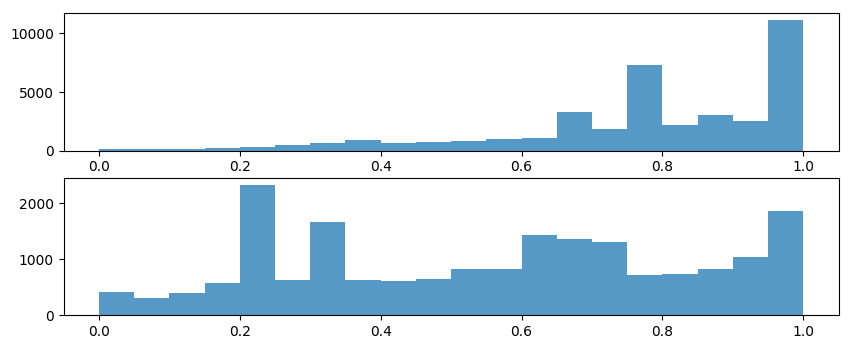

CPU times: user 3min 17s, sys: 920 ms, total: 3min 18s
Wall time: 3min 17s


In [4]:
%%time
# Raw LR, use all imports, dataset balanced as is (more goodware than malware)
# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 76495
Goodware in dataset: 76495
CC:	0.7400
DR:	0.6918
FP:	0.2373
FN:	0.2786

Malware stats:


count    1.899700e+04
mean     6.780426e-01
std      2.470366e-01
min      1.701677e-11
25%      4.725611e-01
50%      7.497619e-01
75%      8.856013e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    1.925100e+04
mean     6.723212e-01
std      2.594752e-01
min      1.712317e-08
25%      5.274389e-01
50%      6.427257e-01
75%      9.298762e-01
max      1.000000e+00
dtype: float64

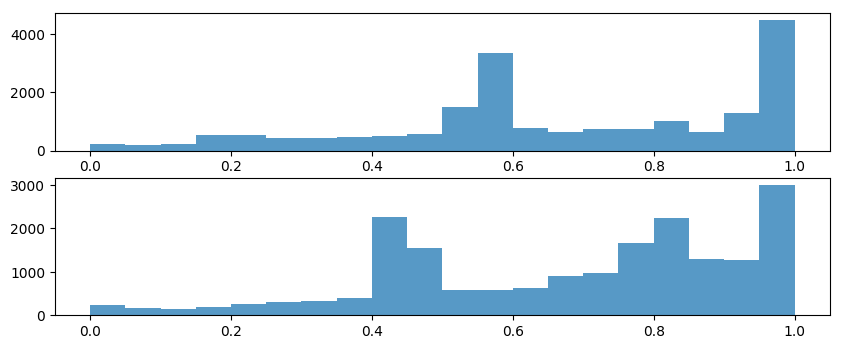

CPU times: user 1min 59s, sys: 413 ms, total: 2min
Wall time: 1min 59s


In [5]:
%%time
# Use all imports, but balance the datasets
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
goodware = dataset[dataset.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset2 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset2[dataset2.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset2[dataset2.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset2, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 76495
Goodware in dataset: 38247
CC:	0.7704
DR:	0.9201
FP:	0.2243
FN:	0.2493

Malware stats:


count    19039.000000
mean         0.779839
std          0.204052
min          0.000004
25%          0.646825
50%          0.857294
75%          0.937932
max          1.000000
dtype: float64


Goodware stats:


count    9.647000e+03
mean     5.557763e-01
std      2.992010e-01
min      1.002123e-07
25%      3.531746e-01
50%      4.604271e-01
75%      8.838963e-01
max      1.000000e+00
dtype: float64

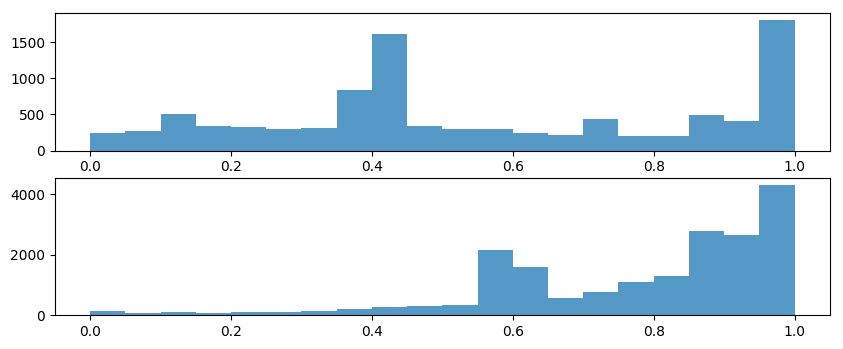

CPU times: user 1min 11s, sys: 330 ms, total: 1min 11s
Wall time: 1min 11s


In [6]:
%%time
# Use all imports, but use more malware for training (more goodware version is default)
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset[dataset.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset3 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset3[dataset3.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset3[dataset3.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset3, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 63786
Goodware in dataset: 116125
CC:	0.7863
DR:	0.6493
FP:	0.2793
FN:	0.1829

Malware stats:


count    1.595900e+04
mean     6.002115e-01
std      2.714033e-01
min      5.613875e-07
25%      3.564562e-01
50%      6.497297e-01
75%      8.214613e-01
max      9.999995e-01
dtype: float64


Goodware stats:


count    29019.000000
mean         0.778693
std          0.227170
min          0.000017
25%          0.677956
50%          0.851618
75%          0.981903
max          1.000000
dtype: float64

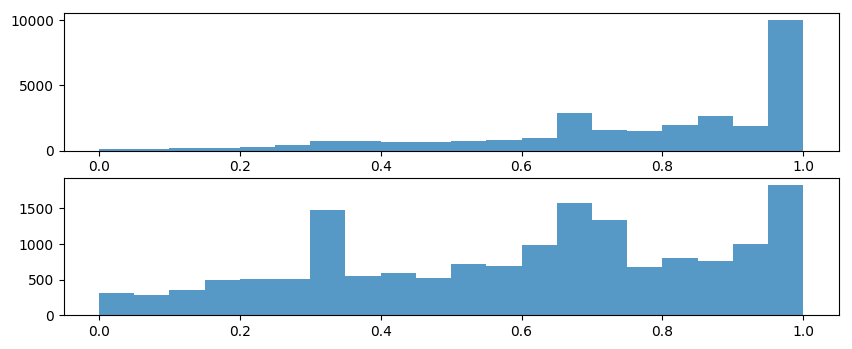

CPU times: user 1min 5s, sys: 370 ms, total: 1min 5s
Wall time: 1min 5s


In [7]:
%%time
# Use between 2 and 300 imports (+/- mean + std for goodware), without balancing
# Filter samples by the number of imports
dataset4 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]

print('Malware in dataset: {}'.format(len(dataset4[dataset4.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset4[dataset4.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset4, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports) 
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 63786
Goodware in dataset: 63786
CC:	0.7608
DR:	0.7540
FP:	0.2383
FN:	0.2401

Malware stats:


count    1.583100e+04
mean     6.964079e-01
std      2.467603e-01
min      4.630831e-08
25%      5.071860e-01
50%      7.668294e-01
75%      8.941941e-01
max      9.999999e-01
dtype: float64


Goodware stats:


count    16062.000000
mean         0.696955
std          0.274528
min          0.000001
25%          0.528338
50%          0.759231
75%          0.963664
max          1.000000
dtype: float64

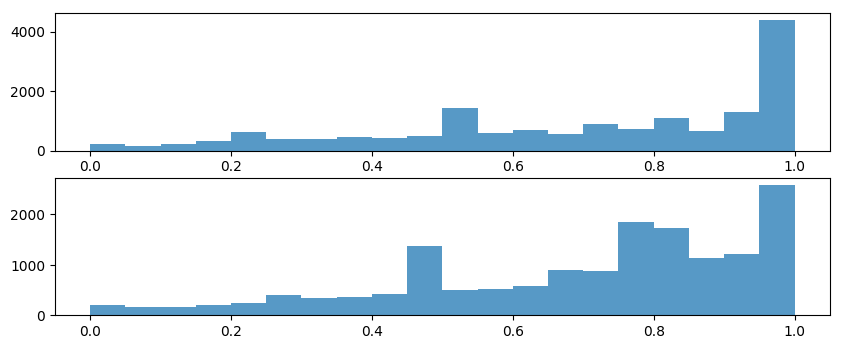

CPU times: user 39.7 s, sys: 317 ms, total: 40 s
Wall time: 39.6 s


In [8]:
%%time
# Use between 2 and 300 imports, balanced dataset
dataset5 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset5[dataset5.malware == 1])
goodware_count = len(dataset5[dataset5.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset5[dataset5.malware == 1].sample(n=limiting)
goodware = dataset5[dataset5.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset5 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset5[dataset5.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset5[dataset5.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset5, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 63786
Goodware in dataset: 31893
CC:	0.7953
DR:	0.9066
FP:	0.1899
FN:	0.2489

Malware stats:


count    16007.000000
mean         0.796882
std          0.207741
min          0.000103
25%          0.687016
50%          0.872823
75%          0.949256
max          1.000000
dtype: float64


Goodware stats:


count    7.913000e+03
mean     5.934078e-01
std      3.156480e-01
min      5.681199e-07
25%      3.502384e-01
50%      5.974897e-01
75%      9.304101e-01
max      1.000000e+00
dtype: float64

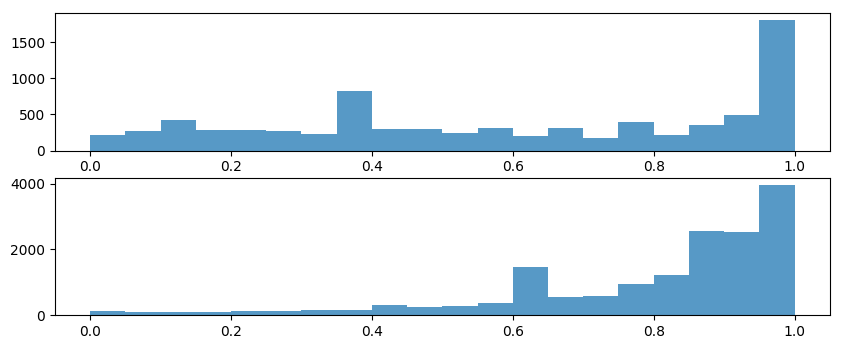

CPU times: user 34.1 s, sys: 280 ms, total: 34.4 s
Wall time: 34 s
Parser   : 113 ms


In [9]:
%%time
# Use up to 300 imports, but with more malware than goodware
dataset6 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset6[dataset6.malware == 1])
goodware_count = len(dataset6[dataset6.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset6[dataset6.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset6[dataset6.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset6 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset6[dataset6.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset6[dataset6.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset6, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()